In [1]:
using SymbolicNumericIntegration
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers
using DoubleFloats

In [3]:
@variables x y t;
dx(exprs) = simplify(expand_derivatives(Differential(x)(exprs)))
dy(exprs) = simplify(expand_derivatives(Differential(y)(exprs)))
dt(exprs) = simplify(expand_derivatives(Differential(t)(exprs)))
u = (sin(y/2))^7
v = sin(π*t/2)*(sin(x/2))^7
p = (sin((x+2π*t)/2)*sin((y+2π*t)/2))^2 - 1/4

display(dx(u)+dy(v))
f1_ode = -(μ/ρ)*(dx(dx(u)) + dy(dy(u))) + dx(p)/ρ + dt(u)
f2_ode = -(μ/ρ)*(dx(dx(v)) + dy(dy(v))) + dy(p)/ρ + dt(v)
display(f1_ode)
display(f2_ode)
f1_ode = eval(build_function(f1_ode,x,y,t))
f2_ode = eval(build_function(f2_ode,x,y,t))
true_v1_ode = eval(build_function(u,x,y,t))
true_v2_ode = eval(build_function(v,x,y,t))
true_p_ode = eval(build_function(p,x,y,t))


0

0

#28 (generic function with 1 method)

In [4]:
@variables ϵ r x₁ x₂ ;
μ = 1.0
ρ = 1.0
#ϕ2 = exp(-r^2*ϵ^2)
#ϕ = (1.0-r*ϵ)^8 * (32.0*(r*ϵ)^3 + 25.0* (r*ϵ)^2 + 8.0*r*ϵ + 1.0)
#ϕ = (1-r*ϵ)^10 * (429*(r*ϵ)^4 + 450*(r*ϵ)^3 + 210*(r*ϵ)^2 + 50*(r*ϵ)+5)
ϕ = r^7
ϕ2 =r^3
#ϕ = (1-r*ϵ)^4 * (4r*ϵ+1)
ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)) 
#ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2))
ϕ = simplify(ϕ,expand = true)
display(ϕ)  
#Δ(exprs) = expand_derivatives((Differential(x₁)^2)(exprs) + (Differential(x₂)^2)(exprs))
#∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)) + expand_derivatives(Differential(r)(exprs)) * (x₁/r),expand = true)
#∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)) + expand_derivatives(Differential(r)(exprs)) * (x₂/r),expand = true)
∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)))
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)))
Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))


Φ_div = ([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)) 0; ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ)) 0; 0 0 ϕ2])
Φ_div = substitute.(Φ_div,r=>sqrt(x₁^2 + x₂^2))


λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ1y(x) = -(μ/ρ)*Δ(x[1]) -  (1/ρ)*∂₁(x[3]) #- ∂₁(x[1]) - ∂₂(x[1])
λ2y(x) = -(μ/ρ)*Δ(x[2]) -  (1/ρ)*∂₂(x[3]) #- ∂₁(x[2]) - ∂₂(x[2])
λ3y(x) = x[1]
λ4y(x) = x[2]

λ1x(x) = -(μ/ρ)*Δ(x[1]) + (1/ρ)*∂₁(x[3]) #+ ∂₁(x[1]) + ∂₂(x[1])
λ2x(x) = -(μ/ρ)*Δ(x[2]) +  (1/ρ)*∂₂(x[3]) #+ ∂₁(x[2]) + ∂₂(x[2])
λ3x(x) = x[1]
λ4x(x) = x[2]

display(Φ_div)



sqrt(x₁^2 + x₂^2)^7

3×3 Matrix{Num}:
 (-7//1)*(sqrt(x₁^2 + x₂^2)^5) - (35//1)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)  …                    0
                                  (35//1)*x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                       0
                                                                    0     sqrt(x₁^2 + x₂^2)^3

In [5]:
K = construct_kernel_array(Φ_div,[λ1x,λ2x,λ3x,λ4x],[λ1y,λ2y,λ3y,λ4y])
display(K)
#K = substitute.(K, sqrt(x₁^2+x₂^2) => r)
#K = substitute.(K, (Dict([x₁ => r, x₂ =>r]),))
#display(K)
K = compile_kernel_array(K)

KE = construct_kernel_array(Φ_div,[λu,λv,λp],[λ1y,λ2y,λ3y,λ4y])
#display(KE)
KE = compile_kernel_array(KE)

KEode = construct_kernel_array(Φ_div,[λu,λv],[λ1y,λ2y,λ3y,λ4y]) # testing for ODEs
KEode = compile_kernel_array(KEode)

P_list2D = generate_2D2_div_free_poly_basis(3)
P_list1D = generate_2D1_poly_basis(2)

#println(K[1,1]([1e-40,1e-40],1.0))

P_list = []
for p2 in P_list2D
    append!(P_list, [vcat(p2,Num(0.0))])
end

#append!(P_list, [vcat(Num(0),Num(0),Num(1))])
for p1 in P_list1D[2:end]
    append!(P_list, [vcat(Num(0.0),Num(0.0),p1)])
end

#display(P_list)
F_P = apply_functionals_to_polynomials([λ1x,λ2x,λ3x,λ4x],P_list)
display(F_P)
F_P = compile_polynomials(F_P)

F_PE = apply_functionals_to_polynomials([λu,λv,λp],P_list)
display(F_PE)
F_PE = compile_polynomials(F_PE)

F_PEode = apply_functionals_to_polynomials([λu,λv],P_list) # testing for ODEs
F_PEode = compile_polynomials(F_PEode)

N_poly = size(F_P)[2]


#display(P_list2D)

#display(substitute.(K, x₁=>r ))

4×4 Matrix{Num}:
  105.0(x₁^4)*(sqrt(x₁^2 + x₂^2)^-3) + 1785.0(x₂^4)*(sqrt(x₁^2 + x₂^2)^-3) + 1890.0(x₁^2)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^-3) - 2523.0sqrt(x₁^2 + x₂^2) - 315.0(x₂^6)*(sqrt(x₁^2 + x₂^2)^-5) - 1263.0(x₁^2)*(sqrt(x₁^2 + x₂^2)^-1) - 6300.0(x₂^2)*(sqrt(x₁^2 + x₂^2)^-1) - 315.0(x₁^4)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^-5) - 630.0(x₁^2)*(x₂^4)*(sqrt(x₁^2 + x₂^2)^-5)  …                                                                  -105.0x₁*(x₂^3)*(sqrt(x₁^2 + x₂^2)^-1) - 630.0x₁*x₂*sqrt(x₁^2 + x₂^2) - 105.0x₂*(x₁^3)*(sqrt(x₁^2 + x₂^2)^-1)
  315.0x₁*(x₂^5)*(sqrt(x₁^2 + x₂^2)^-5) + 315.0x₂*(x₁^5)*(sqrt(x₁^2 + x₂^2)^-5) + 5037.0x₁*x₂*(sqrt(x₁^2 + x₂^2)^-1) + 630.0(x₁^3)*(x₂^3)*(sqrt(x₁^2 + x₂^2)^-5) - 1680.0x₂*(x₁^3)*(sqrt(x₁^2 + x₂^2)^-3) - 1680.0x₁*(x₂^3)*(sqrt(x₁^2 + x₂^2)^-3)                                                                                                                                                                              140.0(sqrt(x₁^2 + x₂^2)^3) + 105.0(x₁^4)*(

4×19 Matrix{Num}:
 0.0   0.0    0.0    -2.0               0.0  …  0.0  1.0    0.0  x₂    2x₁
 0.0   0.0    0.0     0.0               1.0     1.0  0.0  2x₂    x₁      0.0
 1    x₂     x₁    x₂^2             x₁*x₂       0.0  0.0    0.0   0.0    0.0
 0.0   0.0  -x₂       0.0  (-1//2)*(x₂^2)       0.0  0.0    0.0   0.0    0.0

3×19 Matrix{Num}:
 1    x₂     x₁    x₂^2    …   0.0   0.0     0.0      0.0     0.0
 0.0   0.0  -x₂       0.0      0.0   0.0     0.0      0.0     0.0
 0.0   0.0    0.0     0.0     x₂    x₁    x₂^2    x₁*x₂    x₁^2

19

done(819,)

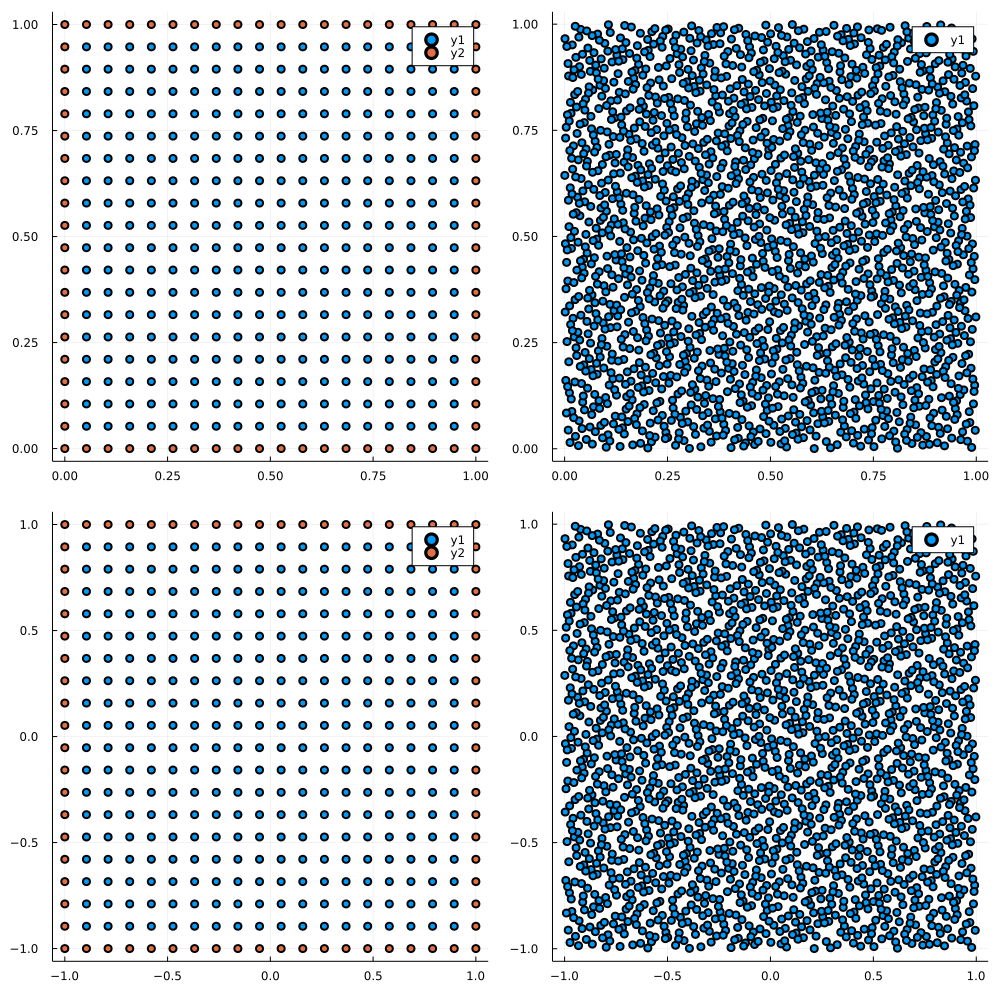

In [7]:
scale = 2
shift = 0.5
N_coll = 20
N_test = 2000
I_points,B_points = generate_2D_equally_spaced_points(N_coll) 
I_points = I_points .*2π
B_points = B_points .*2π
N_I = size(I_points)[2]
N_B = size(B_points)[2]
All_points = hcat(I_points,B_points)
All_points = All_points
#Test_points = hcat(generate_2D_equally_spaced_points(117)...)
Test_points = generate_2D_Halton_points(N_test)
N_tot = size(All_points)[2]

I_points2 = scale*(I_points .- shift)
B_points2 = scale*(B_points .- shift)
Test_points2  = scale*(Test_points .- shift)


f = vcat(f1.(I_points[1,:],I_points[2,:]),f2.(I_points[1,:],I_points[2,:]))
b = vcat(true_v1.(B_points[1,:],B_points[2,:]),true_v2.(B_points[1,:],B_points[2,:]))
b = vcat(f,b,zeros(N_poly))

reference_v = vcat(true_v1.(Test_points[1,:],Test_points[2,:]),true_v2.(Test_points[1,:],Test_points[2,:]))
print("done",size(b))

l = @layout [a b; c d]
p1 = scatter(I_points[1,:], I_points[2,:])
p1 = scatter!(B_points[1,:], B_points[2,:])

p2 = scatter(Test_points[1,:], Test_points[2,:])

p3 = scatter(I_points2[1,:], I_points2[2,:])
p3 = scatter!(B_points2[1,:], B_points2[2,:])

p4 = scatter(Test_points2[1,:], Test_points2[2,:])

plot(p1, p2, p3, p4 ,layout = l,size = (1000,1000))

In [138]:
Aode = crete_block_point_tensors([I_points,I_points,B_points,B_points],[I_points,I_points,B_points,B_points])
Aode = generate_block_matrices(K,Aode,param)
Aode = flatten(Aode)

Eode = crete_block_point_tensors([I_points,I_points],[I_points,I_points,B_points,B_points])
Eode = generate_block_matrices(KEode,Eode,param)
Eode = flatten(Eode)
#display(E)

Oode = zeros(N_poly,N_poly)
Pode = generate_P_matrix([I_points,I_points,B_points,B_points],F_P)
PEode = generate_P_matrix([I_points,I_points],F_PEode)
Mode = [Aode Pode
    Pode' Oode]

Qode = [Eode PEode]
Code = Qode * inv(Mode)
C1 = Code[:,1:2N_I]
C2 = Code[:,1+2N_I:2N_I+2N_B]
println(real.(eigen(-inv(C1)).values))
print("done")
gg(t) = vcat(true_v1_ode.(B_points[1,:],B_points[2,:],t),true_v2_ode.(B_points[1,:],B_points[2,:],t))
ff(t) = vcat(f1_ode.(I_points[1,:],I_points[2,:],t),f2_ode.(I_points[1,:],I_points[2,:],t))
true_sol(t) = vcat(true_v1_ode.(I_points[1,:],I_points[2,:],t),true_v2_ode.(I_points[1,:],I_points[2,:],t))
gg(2)
println("done")


[-579785.7043649096, -204166.88658104005, -188980.57099939752, -113294.73578973931, -85020.83593444969, -71733.27968347153, -70206.71045051151, -70206.71045051151, -44987.36080578655, -44987.36080578655, -34327.957806999075, -32431.75058271952, -32431.75058271952, -30883.185049774253, -28426.489289420002, -23678.9034026777, -21128.430325419427, -21116.47777684818, -21116.47777684818, -18430.109611790536, -17584.826441282687, -17584.826441282687, -16164.533925117476, -16164.533925117476, -15411.899890399523, -15411.899890399523, -14812.187738086423, -14778.260722990817, -14778.260722990817, -14088.067052471608, -12281.745967963263, -12281.745967963263, -12051.905189865945, -12051.905189865945, -11952.497845957045, -11952.497845957045, -11813.362673670532, -11813.362673670532, -11708.734439771899, -10921.795373460309, -10634.765042022136, -10634.765042022136, -10459.842321102773, -10459.842321102773, -10337.50547784696, -10337.50547784696, -10149.616498391802, -10013.573157076298, -9836.

In [139]:
using DifferentialEquations
u0 = vcat(true_v1_ode.(I_points[1,:],I_points[2,:],0),true_v2_ode.(I_points[1,:],I_points[2,:],0))
#display(ff(0))
function f_ode(du,u,p,t)
    C1 = p[1] 
    C2 = p[2]
    du .= -u .+ C1*ff(t) .+ C2*gg(t)
end
ff_ode = ODEFunction(f_ode,mass_matrix = C1)
prob = ODEProblem(ff_ode, u0, (0,1),[C1,C2])
sol = solve(prob,ImplicitEuler(),dt = 0.01)
maximum(sol(1))

┌ Info: Saved animation to 
└   fn = "c:\\Users\\Volodymyr\\OneDrive\\Documents\\Masters\\thesis\\coding\\tmp.gif"


Plots.AnimatedGif("c:\\Users\\Volodymyr\\OneDrive\\Documents\\Masters\\thesis\\coding\\tmp.gif")
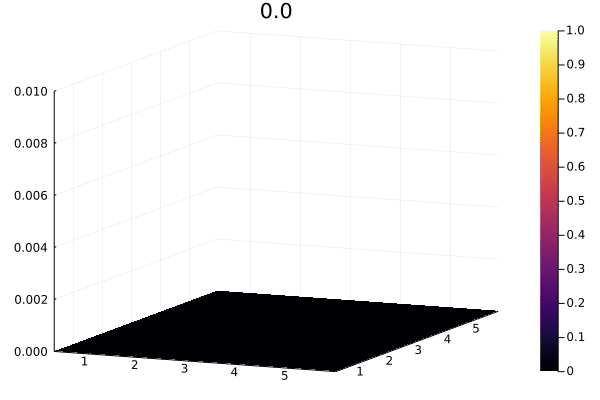

In [132]:
#aaa = batch_solve([10,15,20,25,30,35,40],K,KE,F_P,F_PE)
maximum(true_sol(1))

@gif for i in LinRange(0,1,100)
    err = sol(i) - true_sol(i)
    err = sqrt.(err[1:N_I].^2 .+ err[1+N_I:end].^2)
    surface(I_points[1,:],I_points[2,:],err,zlimits=(0,0.01),label="asasas",legend=:topright,title = i)
end